In [34]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Statistics

This notebook contains plots and other code to explore guesses of the players of the game.

### Table of Content:

* ['Guesses' stats](#guess-stats)
* [Ground truth related stats](#ground-truth-stats)


In [35]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%run ./prepare_data.ipynb






## <a class="anchor" id="guess-stats">Guesses stats</a>

### Most popular and least votes

In [36]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# function creating leaderboard

def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

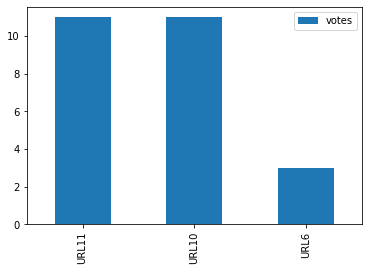

In [37]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links.plot.bar(y='votes'); # plot histogram


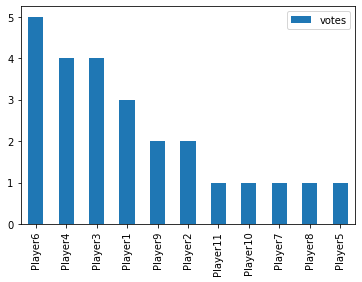

In [38]:
# total votes for each player

total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes.plot.bar(y='votes'); # plot histogram

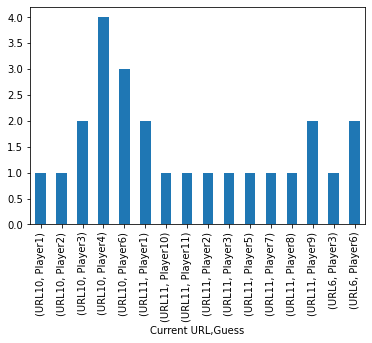

In [39]:
# stats of guesses per URL

guess_stats = df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()
s = pd.Series(guess_stats, name="votes")
df_guess = s.to_frame().sort_values("votes", ascending=False).reset_index()
guess_stats.plot.bar(x='Current URL'); # plot histogram

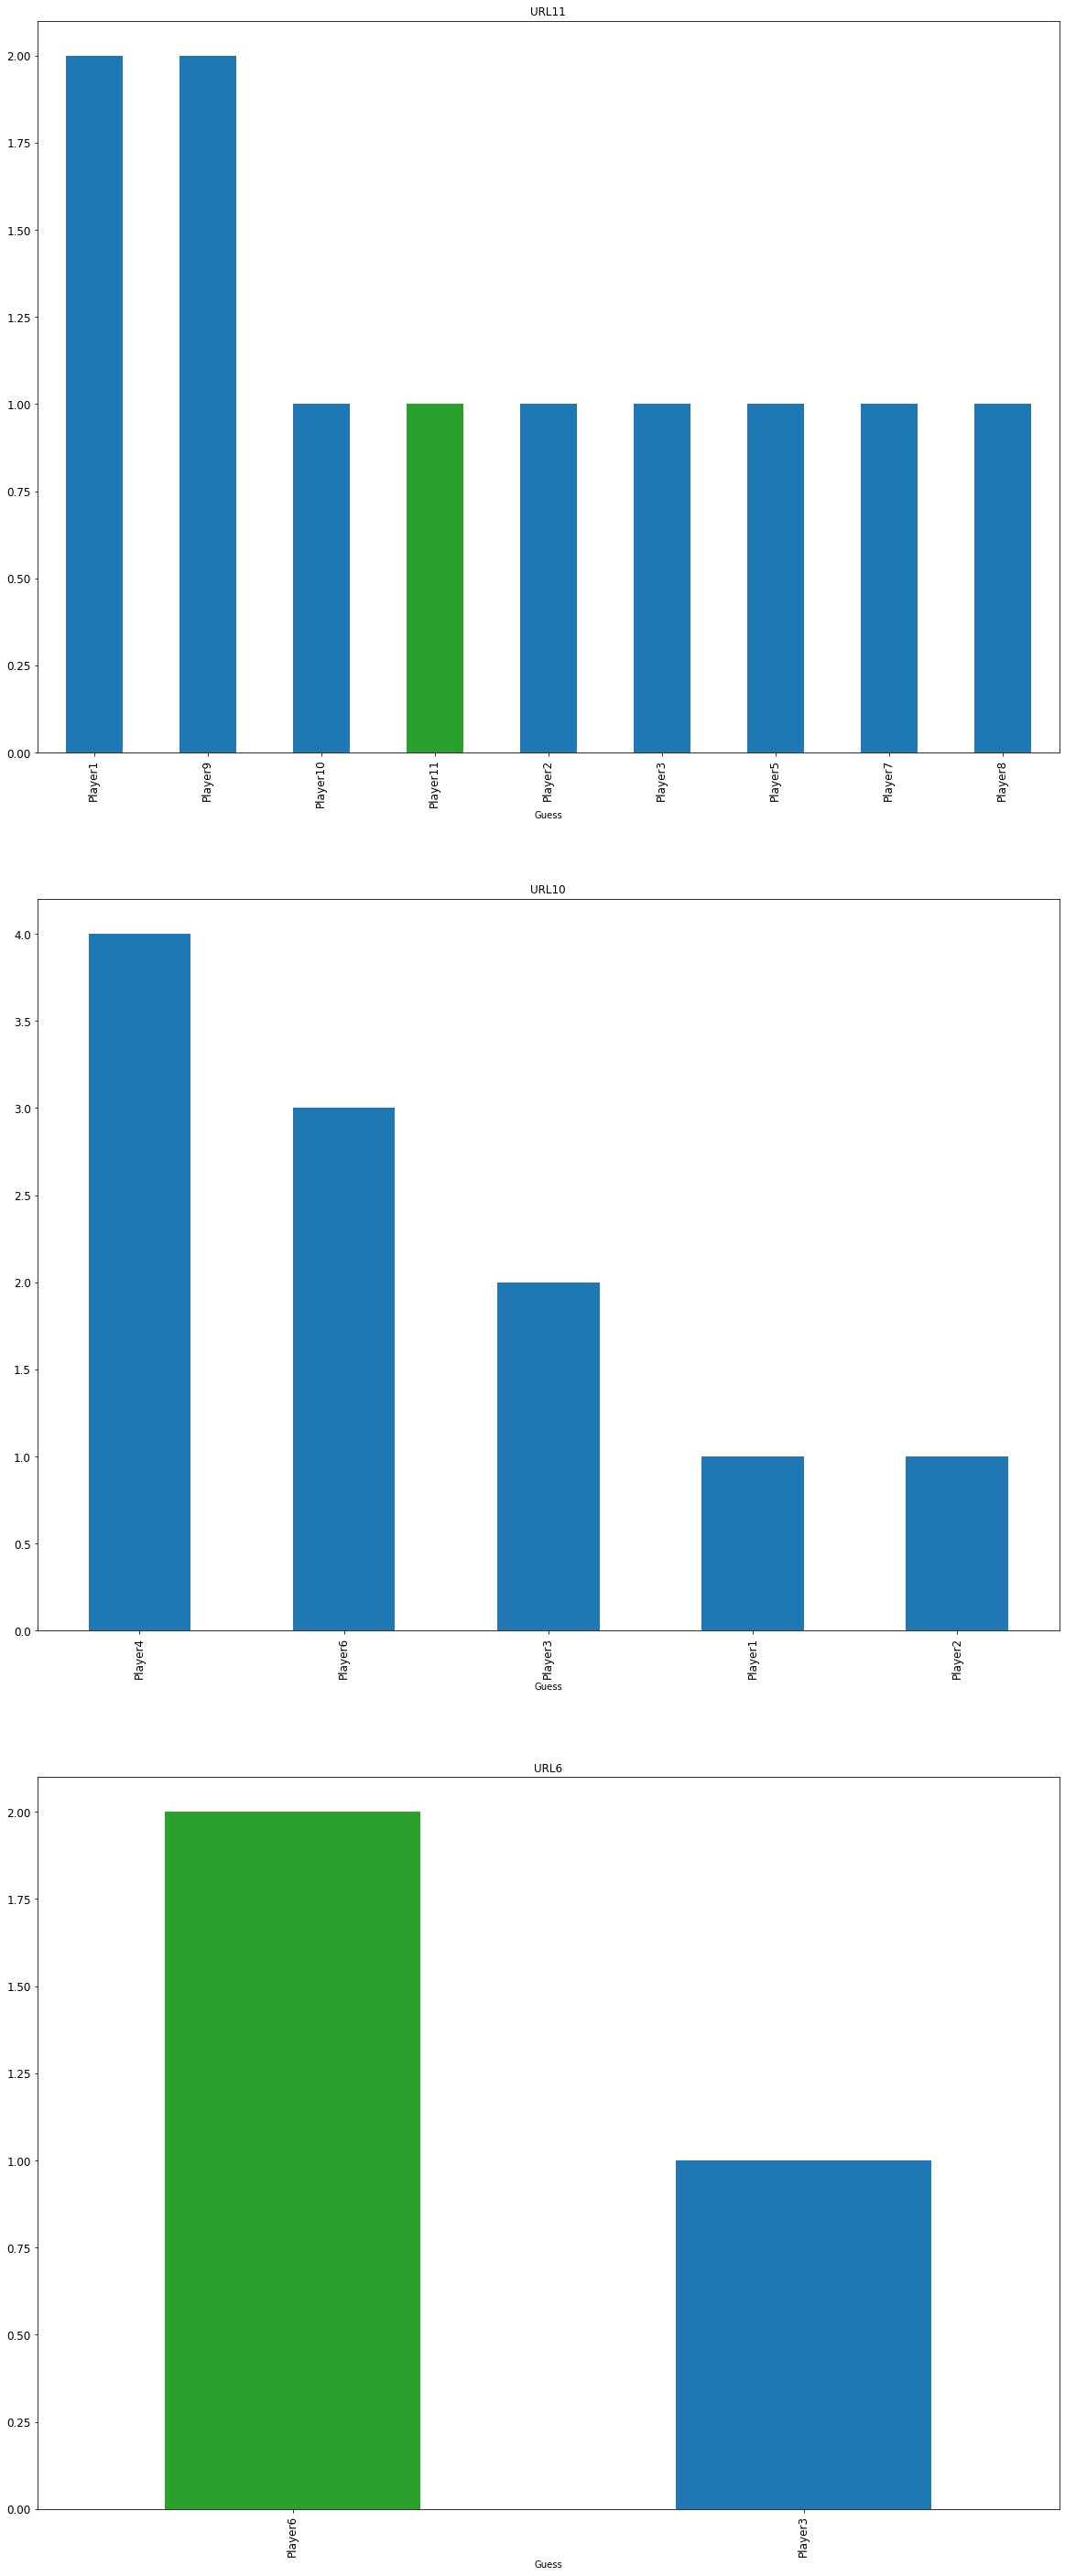

In [40]:
# bar chart per URL, the correct answer is colored in green, the rest of the guesses are blue

fig, axes = plt.subplots(len(urls),1,figsize=(20, 50)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    color=list(map(lambda x: 'C2' if x else 'C0', ind))
    width = len(ind) * [0.2]
    temp_df.loc[:,['Guess','votes']].plot.bar(ax=ax,subplots=True, x='Guess',y='votes',color=color, fontsize=12);
    ax.get_legend().remove()
    ax.set_title(url,fontdict={'fontsize':12})
plt.show()



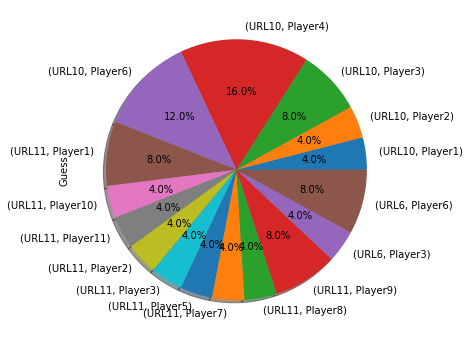

In [41]:
# combined pie chart
guess_stats.plot.pie(subplots=True,y='votes',figsize=(6, 6),autopct='%1.1f%%',shadow = True);

In [42]:
print(df_guess.columns)

Index(['Current URL', 'Guess', 'votes'], dtype='object')


In [43]:
df = df_guess.loc[df_guess['Current URL'] == 'URL6']
df.loc[:,['Guess','votes']]

,Guess,votes
5,Player6,2
15,Player3,1


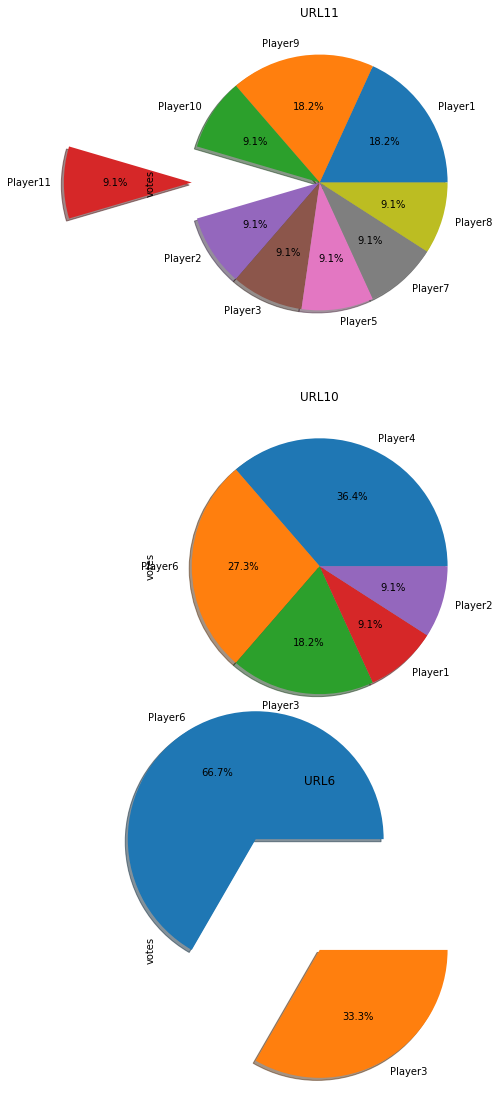

In [44]:
#FIXME: position of correct answer
fig, axes = plt.subplots(len(urls),1,figsize=(30, 20)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    explode=list(map(int, ind))
    temp_df.loc[:,['Guess','votes']].plot.pie(ax=ax,subplots=True,labels = labels, y='votes', autopct='%1.1f%%',shadow = True,explode=explode);
    ax.get_legend().remove()
    ax.set_title(url)
plt.show()


## <a class="anchor" id="ground-truth-stats">Ground truth related stats </a>

First, we compute the intersection between players/url column of ground truth df and guesses/url column of guess df, for all URLs.
Note that one guess is inherently incorrect (by the rules of the game).

In [45]:
#print(df_raw)
#print(df2_raw)

In [46]:
#FIXME: this is not pretty

# Correct guesses
correct_guess_df = pd.merge(df_raw,df2_raw, how='inner', left_on=['Current URL', 'Guess'], right_on=['URL','Player'])
del correct_guess_df['Player_y'], correct_guess_df['URL']
correct_guess_df.rename(columns = {'Player_x':'Player'}, inplace = True)
correct_guess_df

,Current URL,Player,Guess
0,URL11,Player8,Player11
1,URL6,Player9,Player6
2,URL6,Player1,Player6


In [47]:
# Correct guesses per player
#TODO
corr_guess_stats = correct_guess_df.groupby(by=['Player'])['Guess'].count()
print(corr_guess_stats)

Player
Player1    1
Player8    1
Player9    1
Name: Guess, dtype: int64


In [53]:
# Best and worst guessed players
#TODO
corr_url_stats = correct_guess_df.groupby(by=['Current URL'])['Guess'].count()
#corr_url_stats = corr_url_stats.assign(corr_url_stats['Current URL']=df2_raw['Player'])
print(corr_url_stats)

SyntaxError: keyword can't be an expression (<ipython-input-53-b154b26571e1>, line 4)